# Filter snow line time series

Rainey Aberle

2022

In [1]:
# import packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import iqr
from time import mktime
import seaborn as sns
from scipy.stats import median_abs_deviation as mad

# path to snow-cover-mapping
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
figures_out_path = base_path + 'figures/'


In [ ]:
# # Fit a linear trendline to snowline time series
# site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SouthCascade', 'Sperry']

# # -----loop through sites
# nmc = 100 # number of monte carlo simulations
# pTrain = 0.8 # percentage of points to use for training
# for site_name in site_names:
    
#     print(site_name)
#     print('----------')
    
#     # -----Load snowlines             
#     # PlanetScope
#     PS_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
#                                '/imagery/PlanetScope/snowlines/*snowlines.pkl')[0]
#     PS_sl_est = pd.read_pickle(PS_sl_est_path)
#     PS_sl_est['dataset'] = 'PlanetScope'
#     # Sentinel-2
#     S2_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
#                                '/imagery/Sentinel-2/snowlines/*snowlines.pkl')[0]
#     S2_sl_est = pd.read_pickle(S2_sl_est_path)
#     S2_sl_est['dataset'] = 'Sentinel2'
#     # Landsat
#     L_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
#                               '/imagery/Landsat/snowlines/*snowlines.pkl')[0]
#     L_sl_est = pd.read_pickle(L_sl_est_path)
#     L_sl_est['dataset'] = 'Landsat'
    
#     # -----Concatenate snowlines dataframes
#     sl_est_full = pd.concat([PS_sl_est, S2_sl_est, L_sl_est])
#     # unify datetime datatypes
#     sl_est_full['datetime'] = sl_est_full['datetime'].astype(np.datetime64)
#     # add year column
#     sl_est_full['year'] = [x.year for x in sl_est_full['datetime']]
#     # sort df by datetime
#     sl_est_full = sl_est_full.sort_values(by=['datetime'])
#     # grab unique years
#     years = np.unique(sl_est_full['year'])
    
#     # -----Set up figure
#     # fig, ax = plt.subplots(1, len(years), figsize=(6*len(years), 6))
#     fig, ax = plt.subplots(1, 1, figsize=(6*len(years), 6))
#     ax.plot(sl_est_full['datetime'], sl_est_full['snowlines_elevs_median'], 'ok', markersize=10, label='data points')
#     ax.set_ylabel('Snowline elevation [m]')
#     ax.grid()
#     plt.rcParams.update({'font.size':14})

#     # -----Loop through years
#     results_linear_model = pd.DataFrame()
#     for i, year in enumerate(years):
        
#         # subset df
#         sl_est_full_year = sl_est_full.loc[(sl_est_full['year']==year) 
#                                            & (sl_est_full['datetime'] < pd.to_datetime(str(year)+'-10-01'))]
#                                            # & (sl_est_full['datetime'] > pd.to_datetime(str(year)+'-06-01'))]
        
#         # conduct Monte Carlo simulations to generate 100 linear fit models
#         # grab X and Y data from snowline dates and median elevations
#         datetimes = np.ravel(sl_est_full_year['datetime'])
#         snowlines_elevs_median = np.array(np.ravel(sl_est_full_year['snowlines_elevs_median']), dtype=float)
#         # remove NaNs
#         X = datetimes[~np.isnan(snowlines_elevs_median)]
#         if len(X) < 2:
#             print('Not enough data points in ' + str(year) + ' for linear fit, skipping...')
#             continue
#         y = snowlines_elevs_median[~np.isnan(snowlines_elevs_median)]
#         # convert dates to days after the first image date capture
#         day1 = X[0] - np.timedelta64(1, 'D')
#         X = np.array([np.timedelta64(day - day1, 'D') for day in X], dtype=float)
#         # initialize coefficients data frame
#         X_mod = np.linspace(X[0], X[-1], num=100) # points at which to evaluate the model
#         y_mod = np.zeros((nmc, len(X_mod))) # array to hold modeled Y values
#         m_mod = np.zeros(nmc) # linear fit coefficients
#         b_mod = np.zeros(nmc) # linear fit intercepts
#         y_mod_err = np.zeros(nmc) # array to hold error associated with each model
#         # loop through Monte Carlo simulations
#         # fig2, ax2 = plt.subplots(1, 1, figsize=(6,6))
#         for j in np.arange(0,nmc):
#             # split into training and testing data
#             X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=pTrain, shuffle=True)
#             # fit ordinary squares to training data
#             fit = LinearRegression(positive=True).fit(X_train.reshape(-1, 1), y_train)
#             # create weights for each value using the residuals of the ordinary least squares
            
#             # apply fourier model to testing data
#             y_pred = fit.predict(X_test.reshape(-1, 1))
#             # calculate mean error
#             y_mod_err[j] = np.sum(np.abs(y_test - y_pred)) / len(y_test)
#             # apply the model to the full X data
#             y_mod[j,:] = fit.predict(X_mod.reshape(-1, 1))
#             # store the coefficient and intercept
#             m_mod[j] = fit.coef_[0]
#             b_mod[j] = fit.intercept_

#         # identify model with lowest error
#         Ibest = np.argmin(y_mod_err)
#         m_mod_best = m_mod[Ibest]
#         b_mod_best = b_mod[Ibest]
#         y_mod_best = [x*m_mod_best+b_mod_best for x in X_mod]
#         # convert X back to dates
#         X = [np.timedelta64(int(x), 'D')+day1 for x in X]
#         X_mod = [np.timedelta64(int(x), 'D')+day1 for x in X_mod]
        
#         # save results in DataFrame
#         result_linear_model = pd.DataFrame({'year': year,
#                                'X': [X],
#                                'y': [y],
#                                'X_mod': [X_mod],
#                                'y_mod_best': [y_mod_best]
#                               })
#         results_linear_model = pd.concat([results_linear_model, result_linear_model])
        
#         # calculate the IQR and median models
#         # m_mod_iqr, m_mod_median = iqr(m_mod), np.nanmedian(b_mod)
#         # m_mod_P25, m_mod_P75 = m_mod_median - m_mod_iqr/2, m_mod_median + m_mod_iqr/2
#         # b_mod_iqr, b_mod_median = iqr(b_mod), np.nanmedian(b_mod)
#         # b_mod_P25, b_mod_P75 = b_mod_median - b_mod_iqr/2, b_mod_median + b_mod_iqr/2   
#         # y_mod_median = [m_mod_median*x + b_mod_median for x in X_mod]
#         # y_mod_P25 = [m_mod_P25*x + b_mod_P25 for x in X_mod]
#         # y_mod_P75 = [m_mod_P75*x + b_mod_P75 for x in X_mod]
#         # y_mod_iqr = iqr(y_mod, axis=0)
#         # y_mod_median = np.nanmedian(y_mod, axis=0)
#         # y_mod_P25 = y_mod_median - y_mod_iqr/2
#         # y_mod_P75 = y_mod_median + y_mod_iqr/2
        
#         # plot results
#         # ax[i].fill_between(X_mod, y_mod_P25, y_mod_P75, facecolor='blue', alpha=0.5, label='model$_{IQR}$')
#         # ax[i].plot(X_mod, y_mod_median, '.-b', linewidth=1, label='model$_{median}$')
#         if i==1:
#             ax.plot(X_mod, y_mod_best, '-b', linewidth=3, label='best linear model')
#         else:
#             ax.plot(X_mod, y_mod_best, '-b', linewidth=3, label='_nolegend_')
#         ax.legend(loc='best')
#     plt.show()
    
#     # save results in df
#     # results_snowlines = sl_est_full
#     # out_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/' + site_name + '/imagery/'
#     # out_fn = (site_name + '_' + str(np.max(sl_est_full['datetime'])).replace('-','').replace(':','')[0:8]
#     #           + '_' + str(np.max(sl_est_full['datetime'])).replace('-','')[0:8] + '_snowlines.pkl')
#     # results_snowlines.to_pickle(out_path + out_fn)
#     # print('compiled snowlines saved to file: ' + out_path + out_fn)
#     # print(' ')
#     # results_linear_model.to_pickle(out_path + out_fn[0:-4]+ '_linear_model.pkl')
#     # print('snowlines linear model saved to file: ' + out_path + out_fn)
#     # print(' ')
    

In [ ]:
# ### Apply a weighted least squares fit

# site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SouthCascade', 'Sperry']

# # -----loop through sites
# # nmc = 100 # number of monte carlo simulations
# # pTrain = 0.8 # percentage of points to use for training
# # set up figure
# fig, ax = plt.subplots(len(site_names), 1, figsize=(20, 24))
# plt.rcParams.update({'font.size':14})
# for i, site_name in enumerate(site_names):

#     print(site_name)
#     print('----------')
#     ax[i].grid()
#     ax[i].set_title(site_name + ' Glacier')
    
#     # -----Load snowlines             
#     # PlanetScope
#     PS_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
#                                '/imagery/PlanetScope/snowlines/*snowlines.pkl')[0]
#     PS_sl_est = pd.read_pickle(PS_sl_est_path)
#     PS_sl_est['dataset'] = 'PlanetScope'
#     # Sentinel-2
#     S2_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
#                                '/imagery/Sentinel-2/snowlines/*snowlines.pkl')[0]
#     S2_sl_est = pd.read_pickle(S2_sl_est_path)
#     S2_sl_est['dataset'] = 'Sentinel2'
#     # Landsat
#     L_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
#                               '/imagery/Landsat/snowlines/*snowlines.pkl')[0]
#     L_sl_est = pd.read_pickle(L_sl_est_path)
#     L_sl_est['dataset'] = 'Landsat'    
    
#     # -----Concatenate snowlines dataframes
#     sl_est_full = pd.concat([PS_sl_est, S2_sl_est, L_sl_est])
#     # unify datetime datatypes
#     sl_est_full['datetime'] = sl_est_full['datetime'].astype(np.datetime64)
#     # add year column
#     sl_est_full['year'] = [x.year for x in sl_est_full['datetime']]
#     # sort df by datetime
#     sl_est_full = sl_est_full.sort_values(by=['datetime'])
#     # grab unique years
#     years = np.unique(sl_est_full['year'])

#     # -----Loop through years
#     results_linear_model = pd.DataFrame()
#     for j, year in enumerate(years):
        
#         # subset df
#         sl_est_full_year = sl_est_full.loc[(sl_est_full['year']==year) 
#                                            & (sl_est_full['datetime'] < pd.to_datetime(str(year)+'-10-01'))]
#                                            # & (sl_est_full['datetime'] > pd.to_datetime(str(year)+'-06-01'))]
        
#         # conduct Monte Carlo simulations to generate 100 linear fit models
#         # grab X and Y data from snowline dates and median elevations
#         datetimes = np.ravel(sl_est_full_year['datetime'])
#         snowlines_elevs_median = np.array(np.ravel(sl_est_full_year['snowlines_elevs_median']), dtype=float)
#         # remove NaNs
#         X = datetimes[~np.isnan(snowlines_elevs_median)]
#         if len(X) < 2:
#             print('Not enough data points in ' + str(year) + ' for linear fit, skipping...')
#             continue
#         y = snowlines_elevs_median[~np.isnan(snowlines_elevs_median)]
#         # convert dates to days after the first image date capture
#         day1 = X[0] - np.timedelta64(1, 'D')
#         X = np.array([np.timedelta64(day - day1, 'D') for day in X], dtype=float)
#         # initialize coefficients data frame
#         X_mod = np.linspace(X[0], X[-1], num=100) # points at which to evaluate the model
#         # y_mod = np.zeros((nmc, len(X_mod))) # array to hold modeled Y values
#         # m_mod = np.zeros(nmc) # linear fit coefficients
#         # b_mod = np.zeros(nmc) # linear fit intercepts
#         # y_mod_err = np.zeros(nmc) # array to hold error associated with each model
#         # loop through Monte Carlo simulations
#         # for j in np.arange(0,nmc):
#             # split into training and testing data
#         # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=pTrain, shuffle=True)
#         # fit ordinary squares to training data
#         # fit = LinearRegression(positive=True).fit(X_train.reshape(-1, 1), y_train)
#         fit = LinearRegression(positive=True).fit(X.reshape(-1, 1), y)
#         # apply linear model to testing data
#         y_pred = fit.predict(X.reshape(-1, 1))
#         # calculate weights using the inverse of the residuals
#         weights = np.zeros(len(y))
#         for k, yy in enumerate(y):
#             residual = np.abs(y_pred[k] - yy)
#             if residual>0:
#                 weights[k] = 1/(residual**2)
#             else:
#                 weights[k] = 1
#         # fit weighted least squares to data
#         fit_weighted = LinearRegression(positive=True).fit(X.reshape(-1, 1), y, sample_weight=weights)
#         y_pred_weighted = fit_weighted.predict(X_mod.reshape(-1,1))
#         # convert X back to dates
#         X = [np.timedelta64(int(x), 'D')+day1 for x in X]
#         X_mod = [np.timedelta64(int(x), 'D')+day1 for x in X_mod]
#         ax[i].set_ylabel('Snowline elevation [m]')
#         if (i==0) & (j==2):
#             ax[i].plot(X, y_pred, '-r', linewidth=3, label='ordinary least-squares')
#             ax[i].plot(X_mod, y_pred_weighted, '-b', linewidth=3, label='weighted least-squares')
#             ax[i].legend(loc='upper left')
#         else:     
#             ax[i].plot(sl_est_full['datetime'], sl_est_full['snowlines_elevs_median'], 
#                        'ok', markersize=5, label='_nolegend_')
#             ax[i].plot(X, y_pred, '-r', linewidth=3, label='_nolegend_')
#             ax[i].plot(X_mod, y_pred_weighted, '-b', linewidth=3, label='_nolegend_')

#         # create weights for each value using the residuals of the ordinary least squares
#         # weights = [(
#         # calculate mean error
#         # y_mod_err[j] = np.sum(np.abs(y_test - y_pred)) / len(y_test)
#         # # apply the model to the full X data
#         # y_mod[j,:] = fit.predict(X_mod.reshape(-1, 1))
#         # # store the coefficient and intercept
#         # m_mod[j] = fit.coef_[0]
#         # b_mod[j] = fit.intercept_

#         # identify model with lowest error
# #         Ibest = np.argmin(y_mod_err)
# #         m_mod_best = m_mod[Ibest]
# #         b_mod_best = b_mod[Ibest]
# #         y_mod_best = [x*m_mod_best+b_mod_best for x in X_mod]
# #         # convert X back to dates
# #         X = [np.timedelta64(int(x), 'D')+day1 for x in X]
# #         X_mod = [np.timedelta64(int(x), 'D')+day1 for x in X_mod]
        
# #         # save results in DataFrame
# #         result_linear_model = pd.DataFrame({'year': year,
# #                                'X': [X],
# #                                'y': [y],
# #                                'X_mod': [X_mod],
# #                                'y_mod_best': [y_mod_best]
# #                               })
# #         results_linear_model = pd.concat([results_linear_model, result_linear_model])
        
#         # calculate the IQR and median models
#         # m_mod_iqr, m_mod_median = iqr(m_mod), np.nanmedian(b_mod)
#         # m_mod_P25, m_mod_P75 = m_mod_median - m_mod_iqr/2, m_mod_median + m_mod_iqr/2
#         # b_mod_iqr, b_mod_median = iqr(b_mod), np.nanmedian(b_mod)
#         # b_mod_P25, b_mod_P75 = b_mod_median - b_mod_iqr/2, b_mod_median + b_mod_iqr/2   
#         # y_mod_median = [m_mod_median*x + b_mod_median for x in X_mod]
#         # y_mod_P25 = [m_mod_P25*x + b_mod_P25 for x in X_mod]
#         # y_mod_P75 = [m_mod_P75*x + b_mod_P75 for x in X_mod]
#         # y_mod_iqr = iqr(y_mod, axis=0)
#         # y_mod_median = np.nanmedian(y_mod, axis=0)
#         # y_mod_P25 = y_mod_median - y_mod_iqr/2
#         # y_mod_P75 = y_mod_median + y_mod_iqr/2
        
#         # plot results
#         # ax[i].fill_between(X_mod, y_mod_P25, y_mod_P75, facecolor='blue', alpha=0.5, label='model$_{IQR}$')
#         # ax[i].plot(X_mod, y_mod_median, '.-b', linewidth=1, label='model$_{median}$')
#         # if i==1:
#         #     ax.plot(X_mod, y_mod_best, '-b', linewidth=3, label='best linear model')
#         # else:
#         #     ax.plot(X_mod, y_mod_best, '-b', linewidth=3, label='_nolegend_')
#         # ax.legend(loc='best')
# plt.show()
    
# # save figure
# out_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/'
# fig_fn = 'snowline_fitting.png'
# fig.savefig(out_path+fig_fn, facecolor='w', dpi=300)
# print('figure saved to file: '+out_path+fig_fn)

In [ ]:
# ### Filter observations using monthly median values ###
# site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SouthCascade', 'Sperry']

# # -----loop through sites
# for site_name in site_names:
    
#     print(site_name)
#     print('----------')
    
#     # -----Load snowlines    
#     sl_est_path = base_path + '../study-sites/' + site_name + '/imagery/snowlines/'
#     sl_est_fns = glob.glob(sl_est_path + '*snowline.pkl')
#     # compile all snowline files into one DataFrame
#     sl_est_full = pd.DataFrame()
#     for fn in sl_est_fns:
#         sl_est = pd.read_pickle(fn) # read file
#         sl_est_full = pd.concat([sl_est_full, sl_est]) # concatenate to df
#     sl_est_full = sl_est_full.reset_index(drop=True).sort_values(by=['datetime']) # renumber, sort by date
    
#     # -----Reformat snowlines dataframes
#     # unify datetime datatypes
#     sl_est_full['datetime'] = sl_est_full['datetime'].astype(np.datetime64)
#     # add year column
#     sl_est_full['year'] = [x.year for x in sl_est_full['datetime']]
#     # grab unique years
#     years = np.unique(sl_est_full['year'])
#     # set datetime as index
#     sl_est_full.index = sl_est_full['datetime']

#     # -----Set up figure
#     fig, ax = plt.subplots(3, 1, figsize=(12,16))
#     plt.rcParams.update({'font.size':12, 'font.sans-serif':'Arial'})
#     ax[0].plot(sl_est_full.datetime, sl_est_full.snowlines_elevs_median, '.b')
#     xmin, xmax = np.datetime64('2015-05-01'), np.datetime64('2022-11-01')
#     ymin, ymax = sl_est_full.snowlines_elevs_median.min()-25, sl_est_full.snowlines_elevs_median.max()+25
#     ax[0].set_title('Data')
#     ax[0].set_ylabel('Median snowline elevations [m]')
#     ax[0].set_xlim(xmin, xmax)
#     ax[0].set_ylim(ymin, ymax)
#     ax[0].grid()
#     ax[1].set_title('|Data - monthly median trend|')
#     ax[1].set_ylabel('Noise [m]')
#     ax[1].set_xlim(xmin, xmax)
#     ax[1].grid()
#     ax[2].set_title('Filtered data')
#     ax[2].set_ylabel('Median snowline elevations [m]')
#     ax[2].set_xlim(xmin, xmax)
#     ax[2].set_ylim(ymin, ymax)
#     ax[2].grid()
    
#     # -----Filter data points
#     # loop through years
#     sl_est_full_filt = pd.DataFrame()
#     months = np.arange(0,12)
#     # monthly_medians = np.zeros(len(years)*len(months))
#     weeks = np.arange(0,52)
#     i=0 # loop counter
#     for year in years:
#         # subset df to year
#         df_year = sl_est_full[sl_est_full['datetime'].dt.year == year]
#         # add dummy values for Jan - April
#         df_year_dummy = pd.DataFrame()
#         df_year_dummy['datetime'] = np.arange(np.datetime64(str(year)+'-01-01'), 
#                                               np.datetime64(str(year)+'-05-01'), dtype='datetime64[D]')
#         df_year_dummy['snowlines_elevs_median'] = sl_est_full['snowlines_elevs_median'].min()
#         df_year = pd.concat([df_year, df_year_dummy]).sort_values(by=['datetime']).reset_index(drop=True)
#         # add day of year column
#         df_year['doy'] = [x.timetuple().tm_yday for x in df_year['datetime']]
#         # calculate monthly median snowline elevations
#         monthly_medians = [np.nanmedian(df_year[df_year['datetime'].dt.month==month].snowlines_elevs_median)
#                           for month in months]
#         # create array of months in the year
#         dates_interp = np.arange(np.datetime64(str(year)+'-01'), 
#                                  np.datetime64(str(year+1)+'-01'), 
#                                  np.timedelta64(1, 'M'))
#         # plot median trend
#         if year==years[0]:
#             ax[2].plot(dates_interp, monthly_medians, '.-k', label='monthly median trend') 
#         else:
#             ax[2].plot(dates_interp, monthly_medians, '.-k', label='_nolegend_') 
#         # interpolate monthly median at all observation dates
#         monthly_medians_interp = np.interp(df_year['doy'].values, # evaluate at all observation dates
#                                            [pd.Timestamp(x.astype('datetime64[D]') + np.timedelta64(14,'D')).timetuple().tm_yday
#                                             for x in dates_interp], # the 15th of every month
#                                            monthly_medians) # monthly median values
#         # calculate noise, i.e. the difference between each observation and the monthly median trend
#         noise = np.abs(df_year['snowlines_elevs_median'].values - monthly_medians_interp)
        
#         noise_thresh = (sl_est_full['snowlines_elevs_median'].max() 
#                         - sl_est_full['snowlines_elevs_median'].min())*0.4 # [m]
#         # plot noise threshold, noise, and data points to be filtered
#         ax[1].plot([xmin, xmax], [noise_thresh, noise_thresh], '-k', linewidth=2)
#         ax[1].plot(df_year['datetime'], noise, '.r') # plot noise
#         if year==years[0]:
#             ax[2].plot(df_year.iloc[noise >= noise_thresh]['datetime'],
#                        df_year.iloc[noise >= noise_thresh]['snowlines_elevs_median'], 'xr', label='removed points')
#         else:
#             ax[2].plot(df_year.iloc[noise >= noise_thresh]['datetime'],
#                        df_year.iloc[noise >= noise_thresh]['snowlines_elevs_median'], 'xr', label='_nolegend_')            
#         # filter data points using noise threshold
#         df_year.iloc[noise >= noise_thresh, :] = np.nan
#         df_year = df_year.dropna() # remove rows with NaN
#         # plot filtered data points
#         if year==years[0]:
#             ax[2].plot(df_year['datetime'], df_year['snowlines_elevs_median'], '.b', label='filtered time series')
#             ax[2].legend()
#         else:
#             ax[2].plot(df_year['datetime'], df_year['snowlines_elevs_median'], '.b', label='_nolegend_')
#         # concatenate to filtered df
#         sl_est_full_filt = pd.concat([sl_est_full_filt, df_year])
        
        
#     plt.show()
    
#     # save figure
#     fig_fn = figures_out_path + 'filtered_snowline_timeseries_' + site_name + '.png'
#     fig.savefig(fig_fn, dpi=300, facecolor='w')
#     print('figure saved to file: ' + fig_fn)


### Stack observations by year, filter points using the monthly distribution

Wolverine


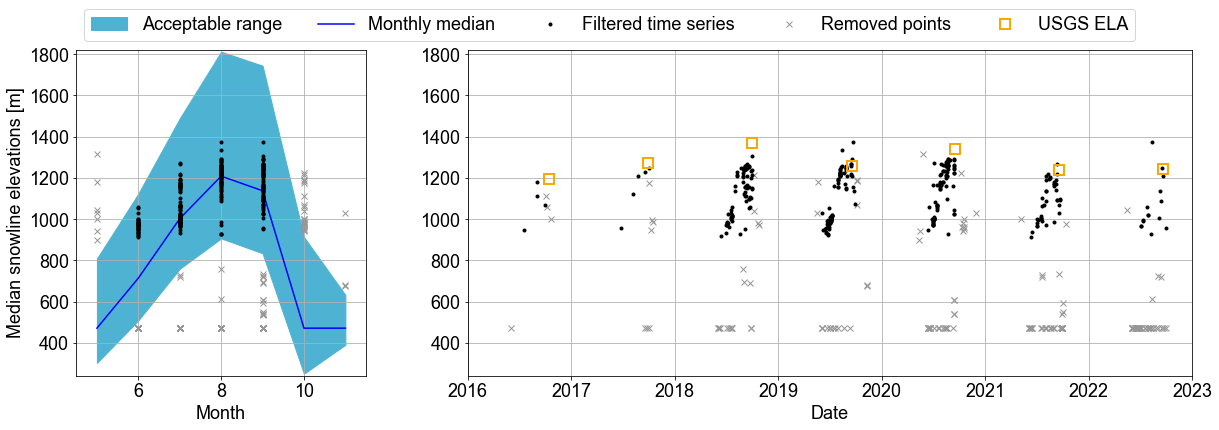

Number of removed points = 161
figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/filtered_snowline_timeseries_Wolverine.png
filtered snowlines save to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/Wolverine/imagery/snowlines/Wolverine_snowlines_filtered_20130519_20221127.pkl
 
Gulkana


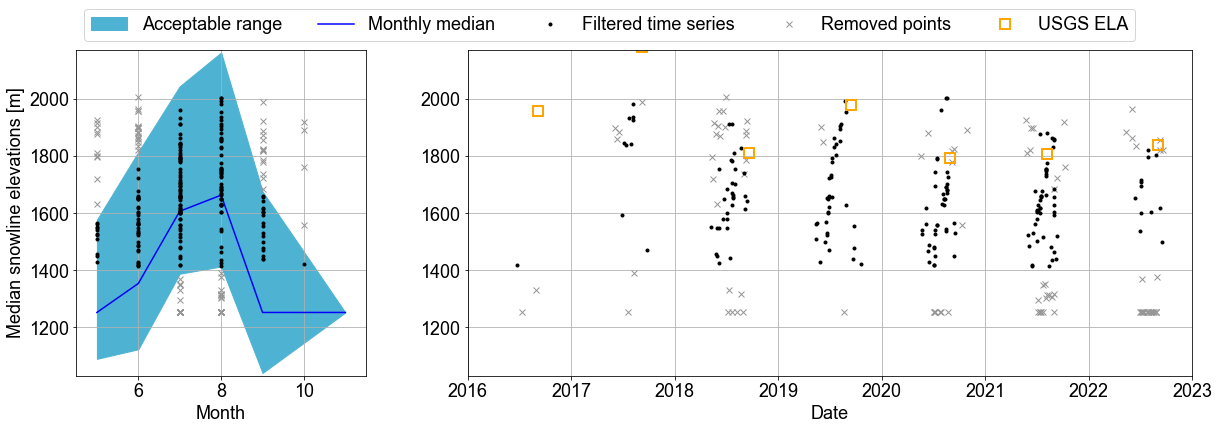

Number of removed points = 98
figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/filtered_snowline_timeseries_Gulkana.png
filtered snowlines save to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/Gulkana/imagery/snowlines/Gulkana_snowlines_filtered_20130526_20221031.pkl
 
LemonCreek


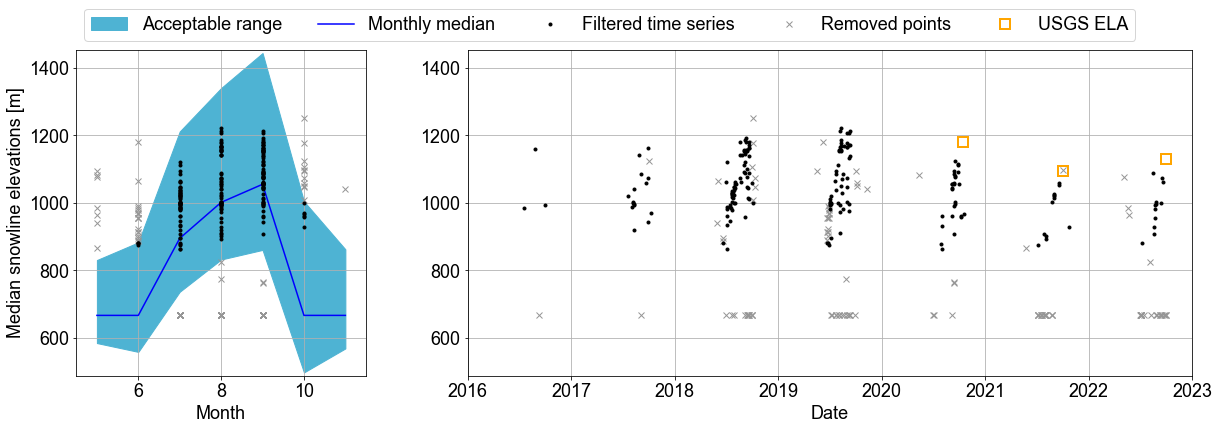

Number of removed points = 111
figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/filtered_snowline_timeseries_LemonCreek.png
filtered snowlines save to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/LemonCreek/imagery/snowlines/LemonCreek_snowlines_filtered_20130520_20221117.pkl
 
SouthCascade


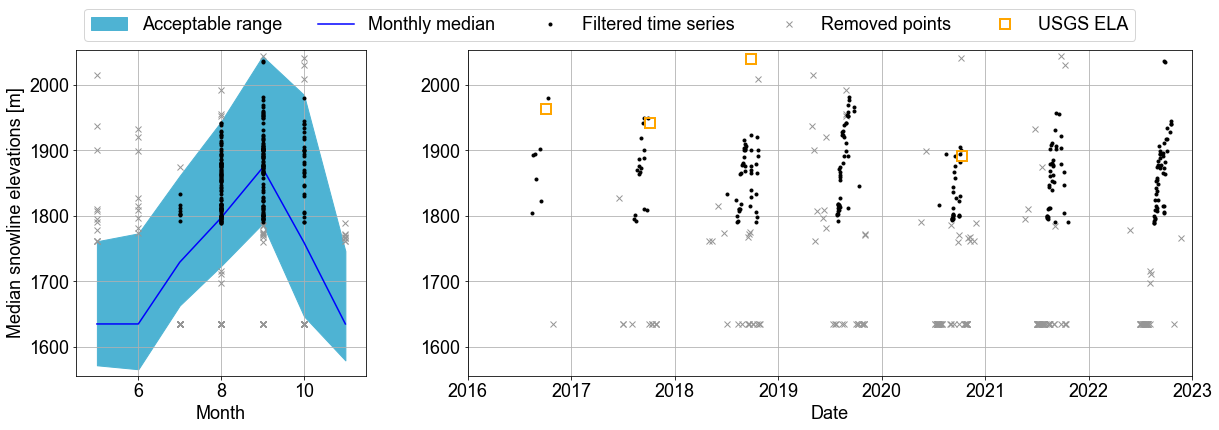

Number of removed points = 185
figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/filtered_snowline_timeseries_SouthCascade.png
filtered snowlines save to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/SouthCascade_snowlines_filtered_20130610_20221123.pkl
 
Sperry


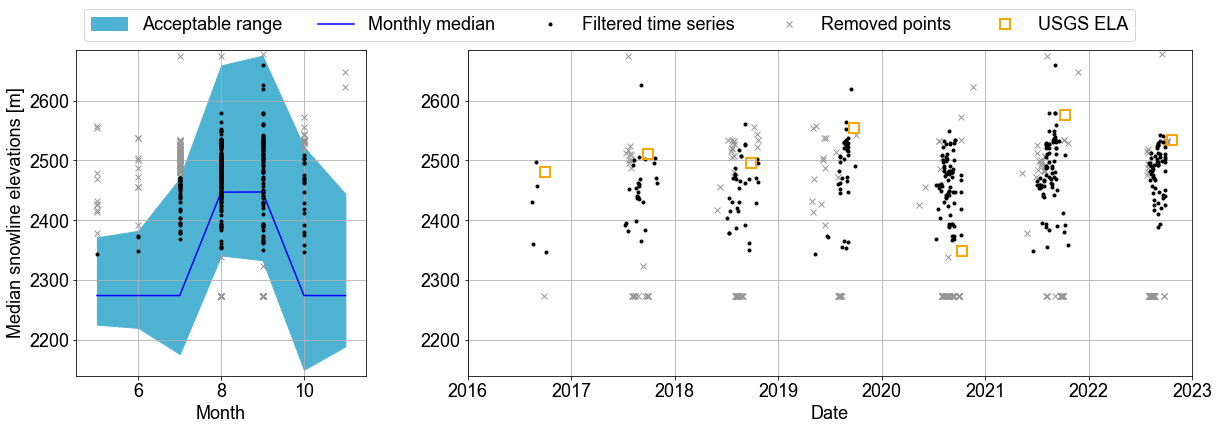

Number of removed points = 227
figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/filtered_snowline_timeseries_Sperry.png
filtered snowlines save to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/Sperry/imagery/snowlines/Sperry_snowlines_filtered_20130630_20221119.pkl
 


In [10]:
# -----Identify site names (used in folder names)
site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SouthCascade', 'Sperry']

# -----Loop through sites
for i, site_name in enumerate(site_names):
    
    print(site_name)
    
    # -----Load snowlines    
    
    ###########################
    ### MODIFY IF NECESSARY ###
    # path to snowline pkl files
    sl_est_path = base_path + '../study-sites/' + site_name + '/imagery/snowlines/' 
    # path where filtered snowlines will be saved
    out_path = sl_est_path 
    # path to USGS mass balance data / ELA csvs (if no USGS files, set usgs_path=None)
    usgs_path = '/Volumes/GoogleDrive/My Drive/Research/PhD/GIS_data/USGS/benchmarkGlacier_massBalance/'
    ###########################
    
    sl_est_fns = glob.glob(sl_est_path + '*snowline.pkl')
    # compile all snowline files into one DataFrame
    sl_est_full = pd.DataFrame()
    for fn in sl_est_fns:
        sl_est = pd.read_pickle(fn) # read file
        sl_est_full = pd.concat([sl_est_full, sl_est]) # concatenate to df
    sl_est_full = sl_est_full.reset_index(drop=True).sort_values(by=['datetime']) # renumber, sort by date
    
    # -----Reformat snowlines dataframes
    # unify datetime datatypes
    sl_est_full['datetime'] = sl_est_full['datetime'].astype(np.datetime64)
    # add month column
    sl_est_full['month'] = [x.month for x in sl_est_full['datetime']]
    # extract all unique months
    months = np.unique(sl_est_full['month'])  
    # set datetime as index
    sl_est_full.index = sl_est_full['datetime']
 
    # ----Set up figure
    fig = plt.figure(figsize=(20, 6))
    plt.rcParams.update({'font.size':18, 'font.sans-serif':'Arial'})
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 2.5])
    # ax0 = fig.add_subplot(spec[0, 0])
    # ax0.axis('off')
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Median snowline elevations [m]')
    ax1.grid()
    ax2 = fig.add_subplot(spec[0, 1])
    ax2.set_xlabel('Date')
    ax2.grid()

    # -----Filter points using median and IQR trend
    med = np.array([np.nanmedian(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median']) for month in months])
    std = np.array([np.nanstd(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median']) for month in months])
    MAD = np.array([mad(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median'], nan_policy='omit') for month in months])
    sl_est_full_filt = sl_est_full.copy() # filtered dataframe
    n_filt = 0 # count number of filtered points
    for j, month in enumerate(months):
        Ifilt = np.ravel(np.argwhere((sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median'] > med[j]+std[j]*2).values |
                        ((sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median'] < med[j]-std[j]).values)))
        n_filt = n_filt + len(Ifilt)
        if len(Ifilt)>0:
            sl_est_full_filt = sl_est_full_filt.mask((sl_est_full_filt['month']==month) & 
                                                     (sl_est_full_filt['snowlines_elevs_median'] > med[j]+std[j]*2) |
                                                     (sl_est_full_filt['snowlines_elevs_median'] < med[j]-std[j]) 
                                                    )
        # removed points
        ax1.plot(sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['month'], 
                 sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['snowlines_elevs_median'], 'x', color='#969696', label='_nolegend_') 
        ax2.plot(sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['datetime'], 
                 sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['snowlines_elevs_median'], 'x', color='#969696')
   
    # -----Plot
    # range of acceptable values
    ax1.fill_between(months, med-std, med+std*2, color='#4eb3d3', label='Acceptable range') 
    # monthly median
    ax1.plot(months, med, '-b', label='Monthly median') 
    # filtered time series
    ax1.plot(sl_est_full_filt['month'], sl_est_full_filt['snowlines_elevs_median'], '.k', label='Filtered time series') 
    ax2.plot(sl_est_full_filt['datetime'], sl_est_full_filt['snowlines_elevs_median'], '.k')
    # removed points (dummy point)
    ax1.plot(0, 0, 'x', color='#969696', label='Removed points')
    # optional: plot USGS ELA estimates
    if usgs_path:
        usgs_fn = usgs_path + site_name+'/Output_'+site_name+'_Glacier_Wide_solutions_calibrated.csv'
        usgs_file = pd.read_csv(usgs_fn)
        ELA = usgs_file['ELA']
        ELA_date = usgs_file['Ba_Date'].astype(np.datetime64)
        ax1.plot(0,0, 's', markerfacecolor='None', markeredgecolor='orange', 
                 ms=10, markeredgewidth=2, label='USGS ELA')
        ax2.plot(ELA_date, ELA, 's', markerfacecolor='None', markeredgecolor='orange', 
                 ms=10, markeredgewidth=2, label='_nolegend_')
    # set axis limits
    ax1.set_xlim(np.min(months)-0.5, np.max(months)+0.5)
    ax2.set_xlim(np.datetime64('2016-01-01'), np.datetime64('2023-01-01'))
    ymin, ymax = np.min(med - std)-10, np.max(med + 2*std)+10
    ax1.set_ylim(ymin, ymax)
    ax2.set_ylim(ymin, ymax)
    # add legend to figure
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(labels))    
    
    plt.show()
    print('Number of removed points = '+str(n_filt))
    
    # -----Save figure
    fig_fn = figures_out_path + 'filtered_snowline_timeseries_' + site_name + '.png'
    fig.savefig(fig_fn, dpi=300, facecolor='w')
    print('figure saved to file: ' + fig_fn)
    
    # -----Save filtered snowline timeseries as csv
    sl_est_full_filt = sl_est_full_filt.dropna().drop(['datetime', 'month'], axis=1)
    sl_fn = (site_name + '_snowlines_filtered_' + str(np.min(sl_est_full['datetime']))[0:10].replace('-','') 
             + '_' + str(np.max(sl_est_full['datetime']))[0:10].replace('-','') + '.pkl')
    sl_est_full_filt.to_pickle(out_path + sl_fn)
    print('filtered snowlines save to file: ' + out_path + sl_fn)
    print(' ')
